<a href="https://colab.research.google.com/github/mamuncseru/deep_understanding_deep_learning/blob/main/Copy_of_DUDL_FFN_Optimizer_LearningRate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [18]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

In [19]:
# shape of the data matrix
data.shape

(20000, 785)

In [20]:
# extract labels (numbers IDs) and remove from data
labels = data[:, 0]
data = data[:, 1:]

print(labels.shape)
print(data.shape)

(20000,)
(20000, 784)


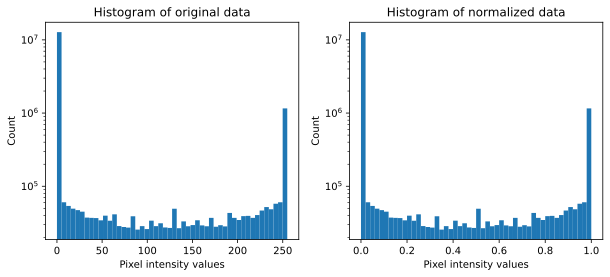

In [21]:
# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(data.flatten(), 50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title("Histogram of original data")
ax[0].set_yscale('log')

ax[1].hist(dataNorm.flatten(), 50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')
ax[1].set_yscale('log')

plt.show()

## Create train/test groups using dataloader

In [22]:
# step 1: convert to tensor
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long() # long = int64

# step 2: use scikit learn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=.1)

# step 3: convert into pyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# step 4: translate into dataloader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

## Create the DL model

In [23]:
# create a class for the model

def createTheMNISTNet(optimizerAlgo, learning_rate):

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            ## input layer
            self.input = nn.Linear(784, 64)

            ## hidden layer
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            ## output layer
            self.output = nn.Linear(32, 10)
        
        # forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            
            return torch.log_softmax(self.output(x), axis=1)

        
    net = mnistNet()

    # loss function 
    lossfun = nn.NLLLoss()

    # optimizer
    optimfun = getattr(torch.optim, optimizerAlgo)
    optimizer = optimfun(net.parameters(), lr=learning_rate)

    return net, lossfun, optimizer

In [24]:
# test the model with one batch
net, lossfun, optimizer = createTheMNISTNet('SGD', .01)

X, y = iter(train_loader).next()
yHat = net(X)
# value s are log-probability of each number (0-9)
print(yHat.shape)
# now let's compute the loss
loss = lossfun(yHat, y)
optimizer

torch.Size([32, 10])


SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [25]:
def function2trainTheModel(optimizerAlgo, learning_rate):

    # number of epochs
    numepochs = 60

    # create a new model
    net, lossfun, optimizer = createTheMNISTNet(optimizerAlgo, learning_rate)

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat, axis=1) == y 
            matchesNumeric = matches.float()
            accuracyPct = 100*torch.mean(matchesNumeric) 
            batchAcc.append(accuracyPct) 

        # end of batch loop

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        # compare the following really lon gline of code the training accuracy lines
        testAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()))

    # end epochs
    
    # function output
    return trainAcc, testAcc, losses, net

## Run the model and show the results!

In [26]:
trainAcc, testAcc, losses, net = function2trainTheModel('SGD', .001)

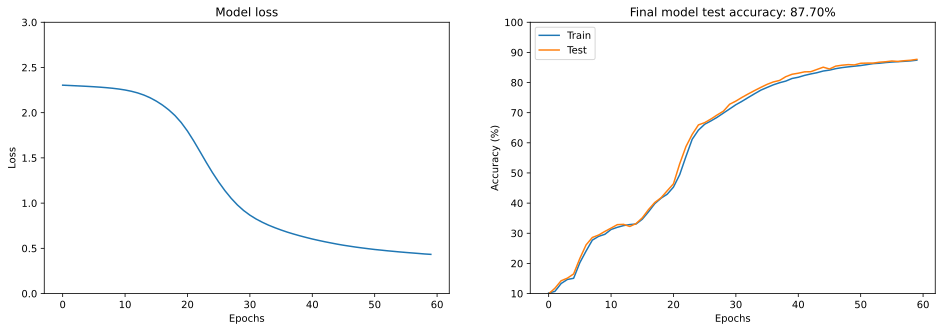

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].set_ylim([10, 100])
ax[1].legend()

plt.show()

## Experiment

In [28]:
# learning rate
learningRates = np.logspace(np.log10(0.0001), np.log10(0.1), 6)
trainAccResults = np.zeros((len(learningRates), 3))
testAccResults= np.zeros((len(learningRates), 3))
# trainAccuracyResults = 
for i, opto in enumerate(['SGD', 'RMSprop', 'Adam']):
    for j, learning_rate in enumerate(learningRates):
        print(f'running optimizer {opto} with learning rate {learning_rate}')
        trainAcc, testAcc, losses, net = function2trainTheModel(opto, learning_rate)

        # store the final results
        trainAccResults[j, i] = np.mean(trainAcc[-10:])
        testAccResults[j, i] = np.mean(testAcc[-10:])
    

running optimizer SGD with learning rate 0.0001
running optimizer SGD with learning rate 0.00039810717055349735
running optimizer SGD with learning rate 0.001584893192461114
running optimizer SGD with learning rate 0.00630957344480193
running optimizer SGD with learning rate 0.025118864315095794
running optimizer SGD with learning rate 0.1
running optimizer RMSprop with learning rate 0.0001
running optimizer RMSprop with learning rate 0.00039810717055349735
running optimizer RMSprop with learning rate 0.001584893192461114
running optimizer RMSprop with learning rate 0.00630957344480193
running optimizer RMSprop with learning rate 0.025118864315095794
running optimizer RMSprop with learning rate 0.1
running optimizer Adam with learning rate 0.0001
running optimizer Adam with learning rate 0.00039810717055349735
running optimizer Adam with learning rate 0.001584893192461114
running optimizer Adam with learning rate 0.00630957344480193
running optimizer Adam with learning rate 0.025118864

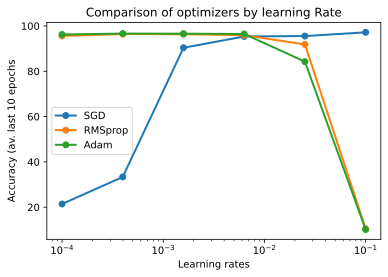

In [29]:
plt.plot(learningRates, testAccResults, 'o-', linewidth=2)
plt.legend(['SGD', 'RMSprop', 'Adam'])
plt.xscale('log')
plt.xlabel('Learning rates')
plt.ylabel('Accuracy (av. last 10 epochs')
plt.title('Comparison of optimizers by learning Rate')
plt.show()